In [1]:
### IMPORTS

import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.odr import ODR, Model, Data, RealData
from scipy import optimize
from scipy import linalg
import uncertainties as unc  
import uncertainties.unumpy as unumpy
from uncertainties import unumpy
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm
import pandas as pd

Welcome to JupyROOT 6.22/00


### Importing data

Regions are divided as follows:
- **CT** for centre cell, single quarter
- **TLL**, top left cell, top left quarter, representing the cell corner case 
- **TLR**, top left cell, top right quarter, representing any edge cell.

In [2]:
def unpack(cell_region):
        xs = []
        ys = []
        ts = []
        errts = []
        for drift_times in cell_region.dtimes:
            xs.append(drift_times.xs)
            ys.append(drift_times.ys)
            ts.append(drift_times.dtime)
            errts.append(drift_times.errdtime)
        return xs, ys, ts, errts

In [3]:
class Cell:
    def __init__(self, region):
        unpacked_region = unpack(region)
        self.x = unpacked_region[0]
        self.y = unpacked_region[1]
        self.t = unpacked_region[2]
        self.errt = unpacked_region[3]
        self.r = np.sqrt(np.array(unpacked_region[0])**2 + np.array(unpacked_region[1])**2)
        

In [4]:
CTL850 = Cell(ROOT.TFile.Open("summaryCTL850.root"))
CTL880 = Cell(ROOT.TFile.Open("summaryCTL880.root"))
CTL910 = Cell(ROOT.TFile.Open("summaryCTL910.root"))
TLL850 = Cell(ROOT.TFile.Open("summaryTLL850.root"))
TLL880 = Cell(ROOT.TFile.Open("summaryTLL880.root"))
TLL910 = Cell(ROOT.TFile.Open("summaryTLL910.root"))
TLR850 = Cell(ROOT.TFile.Open("summaryTLR850.root"))
TLR880 = Cell(ROOT.TFile.Open("summaryTLR880.root"))
TLR910 = Cell(ROOT.TFile.Open("summaryTLR910.root"))

In [5]:
regions = [CTL850, CTL880, CTL910, TLL850, TLL880, TLL910, TLR850, TLR880, TLR910]
cell_names = ["CTL850", "CTL880", "CTL910", "TLL850", "TLL880", "TLL910", "TLR850", "TLR880", "TLR910"]


In [6]:
plt.rcParams['axes.formatter.limits'] = [-5,6]

#### Fitting distance to time

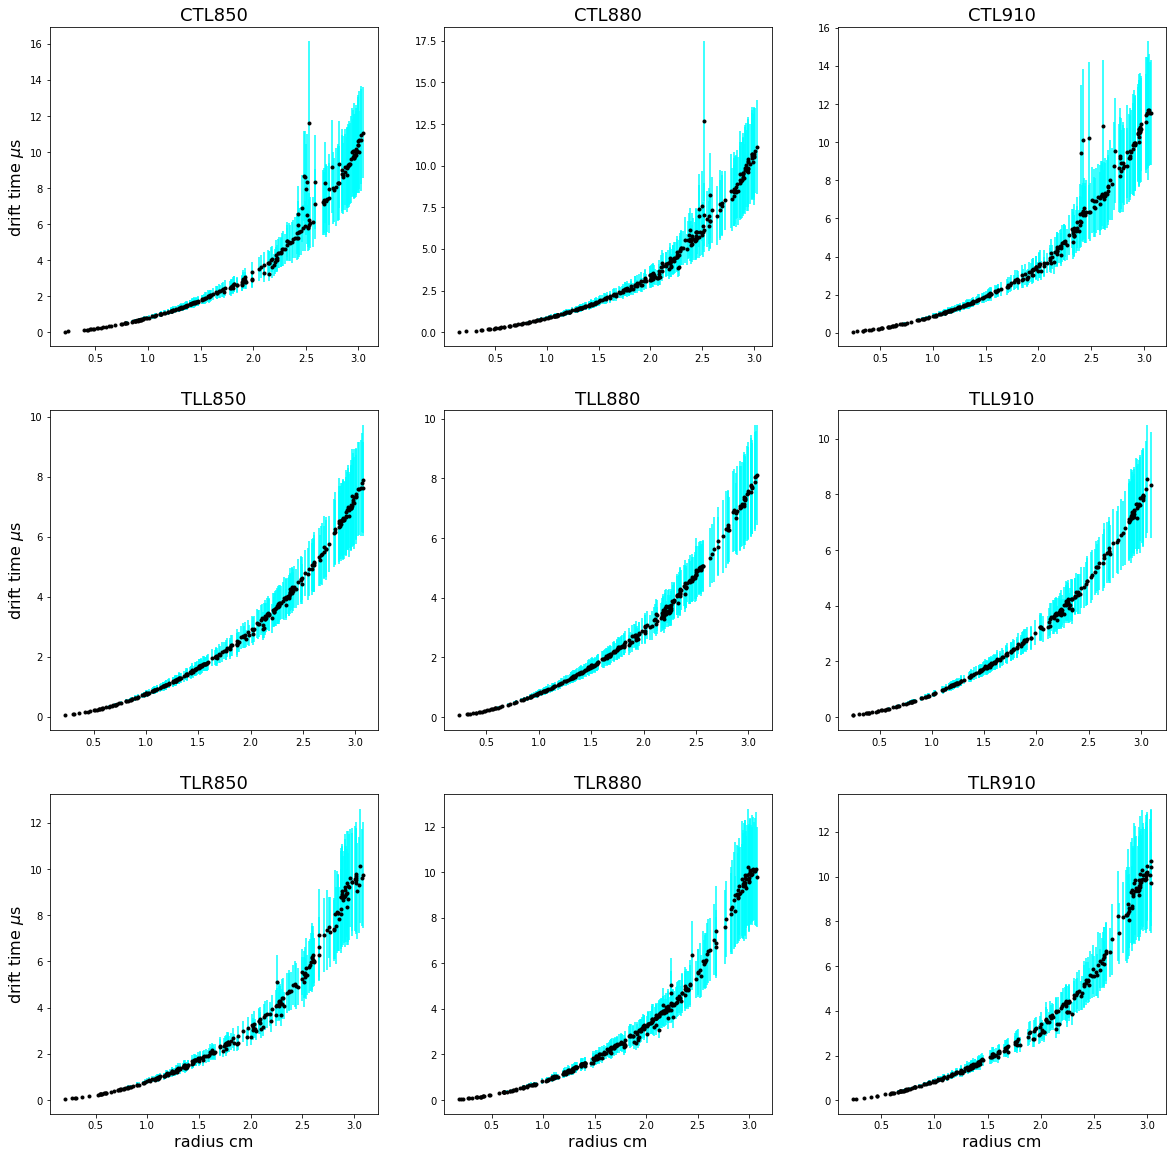

In [7]:
#plot 9 images of the 9 regions
figs, axs = plt.subplots(3,3, figsize=(20,20))
count = 0
for i in range(3):
    for j in range(3):
        label = cell_names[count]
        axs[i,j].errorbar(regions[count].r,np.array(regions[count].t)/1e-6,yerr=np.array(regions[count].errt)/1e-6,fmt='.',ecolor = 'cyan',color='black')
        axs[i,j].set_title(label,fontsize=18)
        axs[i,0].set_ylabel(r'drift time $\mu$s',fontsize=16)
        axs[2,j].set_xlabel('radius cm',fontsize=16)

        count += 1

Drift time equation as a function of radial distance:
$$t(r) = \frac{a \times r}{r^b}$$

**Yorick's initial parameters:**

$0<r<2.2$, a = $1\times 10^{-6}$, b = $-0.9$

$2.2<r<3.5$, a = $1\times 10^{-6}$, b = $-2$


In [8]:
a_guess = 1e-6
b_guess = -0.9
b_guess2 = -2

In [9]:
def trialfunc(r,a,b):
    """ A function that calculates time from distance"""
    denom = r**b
    return a*r / denom

In [10]:
def perform_fit(region,cutoff):
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]

    popt,pcov = curve_fit(trialfunc,r_low,time_low,p0=[a_guess,b_guess],sigma=err_low)
    perr = np.sqrt(np.diag(pcov))
    
    popt2,pcov2 = curve_fit(trialfunc,r_up,time_up,p0=[a_guess,b_guess2],sigma=err_up)
    perr2 = np.sqrt(np.diag(pcov2))

    return popt,perr,popt2,perr2

**Inverse function:** Radial distance as a function of drift time:
$$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$$

**Error propagation:** 
$$\begin{equation}
\sigma_r^2 = \sigma_a^2(\frac{\partial r}{\partial a})^2 + \sigma_b^2(\frac{\partial r}{\partial b})^2 + \sigma_t^2(\frac{\partial r}{\partial t})^2
\end{equation}$$


In [11]:
def invertfunc(t,a,b):
    
    """ A function that calculates distance from time"""
    power = (1/(1-b))
    
    return (t/a)**power

In [12]:
import csv

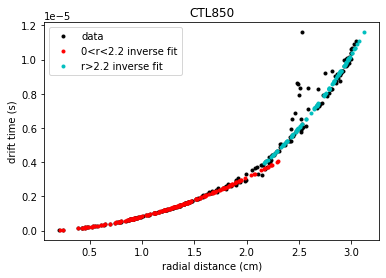

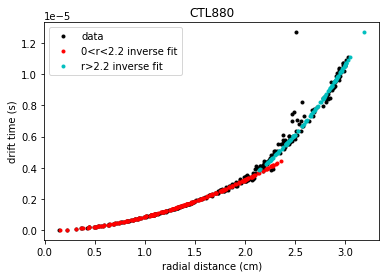

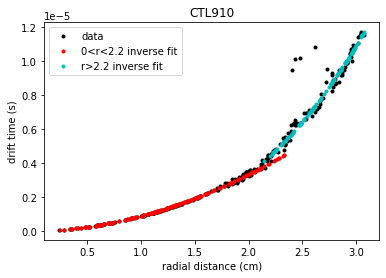

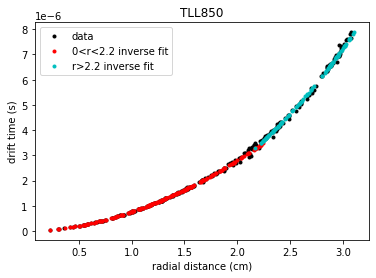

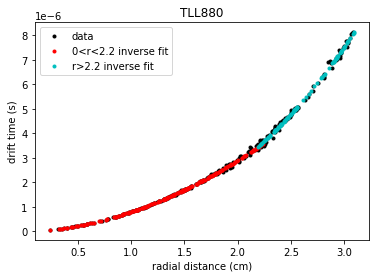

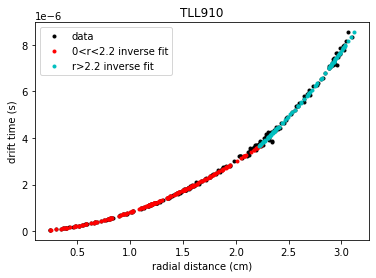

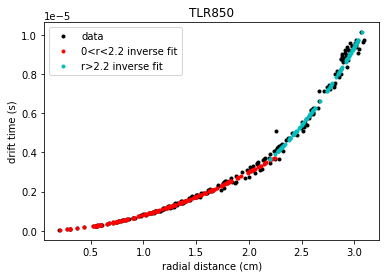

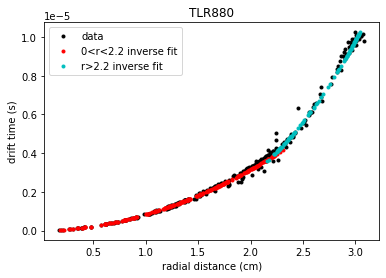

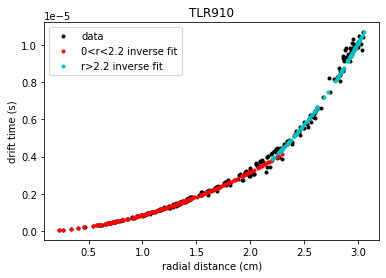

In [13]:
#f2 = open('drift_parameters.csv','w')
#f2.write('{} {} {} {} {} {} {} {}\n'.format('a', 'erra', 'b', 'errb', 'a2', 'erra2', 'b2', 'errb2'))
#f2.write('a', 'erra', 'b', 'errb', 'a2', 'erra2', 'b2', 'errb2')
count = 0
for region in regions:
    popt,perr,popt2,perr2 = perform_fit(region,2.2)
    plt.plot(region.r,region.t,'k.',label='data')
    plt.plot(invertfunc(np.array(region.t)[np.array(region.r)<2.2],popt[0],popt[1]),np.array(region.t)[np.array(region.r)<2.2],'r.',label='0<r<2.2 inverse fit')
    plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=2.2],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=2.2],'c.',label='r>2.2 inverse fit')
    plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
    plt.legend()
    plt.title(cell_names[count])
    plt.xlabel('radial distance (cm)')
    plt.ylabel('drift time (s)')
    plt.show()
    count+=1
    #f2.write('{} {} {} {} {} {} {} {}\n'.format(popt[0],perr[0],popt[1],perr[1],popt2[0],perr2[0],popt2[1],perr2[1]))

In [14]:
## since the asymmetry around 2.2 is largest in centre>edge>corner, expect fit to be worse for CTL>TLR>TLL and this is true

In [15]:
## the problem here is that also depends on where you chose the drift time corresponding to 2.2 to be.

In [16]:
def error_propagation(ts,errts,a,erra,b,errb):
    t_tuple = unumpy.uarray(ts, errts)
    a_tuple = unumpy.uarray(a, erra)
    b_tuple = unumpy.uarray(b, errb)
    r = (t_tuple/a_tuple)**(1/(1-b_tuple))
    err = unumpy.std_devs(r)
    val = unumpy.nominal_values(r)
    return err, val

In [17]:
def inversefit_plot(region,label):
    popt,perr,popt2,perr2 = perform_fit(region,2.2)
    err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
    err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])
    plt.errorbar(region.r,np.array(region.t),yerr=np.array(region.errt),fmt='.',ecolor = 'pink',color='red',label='data')
    plt.errorbar(val1,np.array(region.t)[region.r < 2.2],xerr=err1,fmt='.',ecolor = 'cyan',color='black',label='prediction r<2.2')
    plt.errorbar(val2,np.array(region.t)[region.r >= 2.2],xerr=err2,fmt='.',ecolor = 'green',alpha=0.2,color='black',label='prediction r>2.2')
    plt.legend(loc='upper left')
    plt.title('Inverse fit with error bars'+' '+str(label))
    plt.ylabel(r'drift time (s)')
    plt.xlabel('radial distance (cm)')
    plt.show()

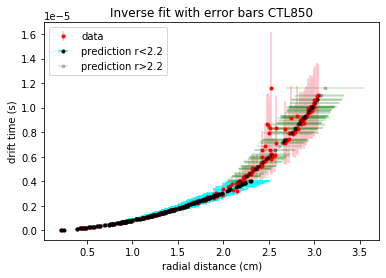

In [18]:
inversefit_plot(CTL850,'CTL850')

In [48]:
regions = [CTL850, CTL880, CTL910, TLL850, TLL880, TLL910, TLR850, TLR880, TLR910]
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions)):
    popt,perr,popt2,perr2 = perform_fit(regions[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])


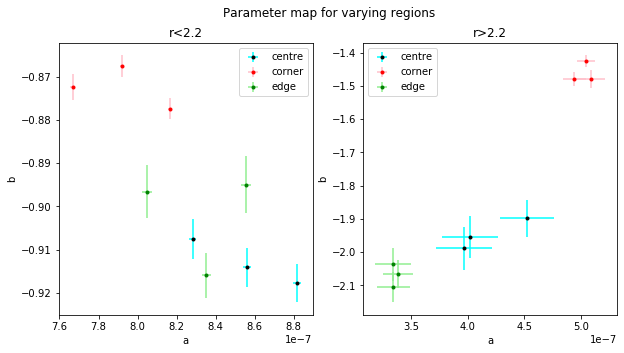

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying regions')


ax1.errorbar(a[0:3],b[0:3],xerr=erra[0:3],yerr=errb[0:3],fmt='.',ecolor = 'cyan',color='black',label='centre')
ax1.errorbar(a[3:6],b[3:6],xerr=erra[3:6],yerr=errb[3:6],fmt='.',ecolor = 'pink',color='red',label='corner')
ax1.errorbar(a[6:9],b[6:9],xerr=erra[6:9],yerr=errb[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='edge')

ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('r<2.2')
ax1.legend()

ax2.errorbar(a2[0:3],b2[0:3],xerr=erra2[0:3],yerr=errb2[0:3],fmt='.',ecolor = 'cyan',color='black',label='centre')
ax2.errorbar(a2[3:6],b2[3:6],xerr=erra2[3:6],yerr=errb2[3:6],fmt='.',ecolor = 'pink',color='red',label='corner')
ax2.errorbar(a2[6:9],b2[6:9],xerr=erra2[6:9],yerr=errb2[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='edge')

ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('r>2.2')
ax2.legend()
plt.show()

In [33]:
regions2 = [TLL850, TLR850, CTL850, TLL880, TLR880, CTL880, TLL910, TLR910, CTL910]
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions2)):
    popt,perr,popt2,perr2 = perform_fit(regions2[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])

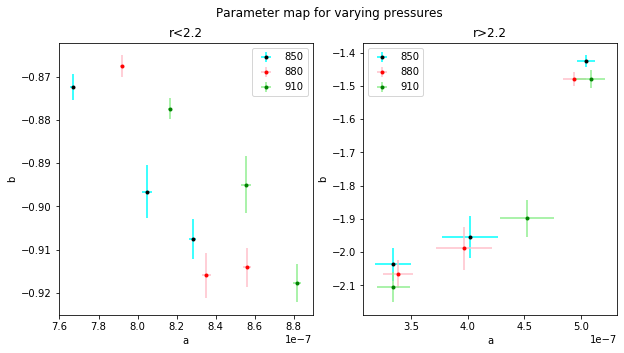

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying pressures')


ax1.errorbar(a[0:3],b[0:3],xerr=erra[0:3],yerr=errb[0:3],fmt='.',ecolor = 'cyan',color='black',label='850')
ax1.errorbar(a[3:6],b[3:6],xerr=erra[3:6],yerr=errb[3:6],fmt='.',ecolor = 'pink',color='red',label='880')
ax1.errorbar(a[6:9],b[6:9],xerr=erra[6:9],yerr=errb[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='910')

ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('r<2.2')
ax1.legend()

ax2.errorbar(a2[0:3],b2[0:3],xerr=erra2[0:3],yerr=errb2[0:3],fmt='.',ecolor = 'cyan',color='black',label='850')
ax2.errorbar(a2[3:6],b2[3:6],xerr=erra2[3:6],yerr=errb2[3:6],fmt='.',ecolor = 'pink',color='red',label='880')
ax2.errorbar(a2[6:9],b2[6:9],xerr=erra2[6:9],yerr=errb2[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='910')

ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('r>2.2')
ax2.legend()
plt.show()

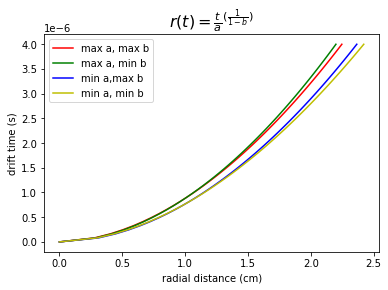

In [23]:
###finding physical meaning of a and b

tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
#plt.plot(r_CTL850,drift_CTL850,'k.',label='data')
plt.plot(invertfunc(tfine,max(a),max(b)),tfine,'r-',label='max a, max b')
plt.plot(invertfunc(tfine,max(a),min(b)),tfine,'g-',label='max a, min b')
plt.plot(invertfunc(tfine,min(a),min(b)),tfine,'b-',label='min a,max b')
plt.plot(invertfunc(tfine,min(a),max(b)),tfine,'y-',label='min a, min b')

#plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'c-',label='r>2.2 inverse fit')
plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

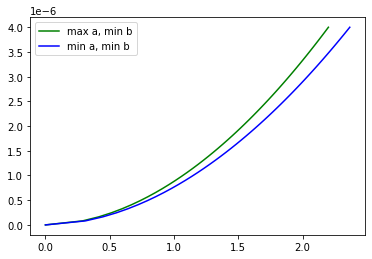

In [24]:
plt.plot(invertfunc(tfine,max(a),min(b)),tfine,'g-',label='max a, min b')
plt.plot(invertfunc(tfine,min(a),min(b)),tfine,'b-',label='min a, min b')
plt.legend()

In [25]:
a_reshape = (np.array(a)/1e-7).reshape(3,3)

In [34]:
b_reshape = np.array(b).reshape(3,3)

In [35]:
Blues = plt.get_cmap('Blues')

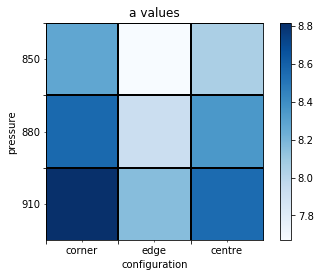

In [36]:
fig, ax = plt.subplots()
u = ax.imshow(a_reshape, cmap=Blues)#, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, 2.5, 1));
ax.set_yticks(np.arange(-.5, 2.5, 1));
ax.set_title('a values')
ax.set_xticklabels(['center','corner','edge'])
ax.set_yticklabels(['850','880','910'])
ax.set_xlabel('configuration')
ax.set_ylabel('pressure')

# Hide major tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')

# Customize minor tick labels
ax.set_xticks([0,1,2],      minor=True)
ax.set_yticks([0,1,2],      minor=True)

ax.set_xticklabels(['corner','edge','centre'],minor=True)
ax.set_yticklabels(['850','880','910'],minor=True)

fig.colorbar(u)
#ax.set_yticks([])
#ax.set_xticks([])

plt.show()

In [37]:
Summer = plt.get_cmap('Reds')

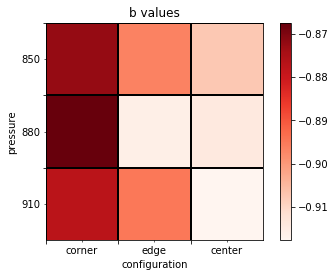

In [40]:
fig, ax = plt.subplots()
u = ax.imshow(b_reshape, cmap=Summer)#, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, 2.5, 1));
ax.set_yticks(np.arange(-.5, 2.5, 1));
ax.set_title('b values')

ax.set_xlabel('configuration')
ax.set_ylabel('pressure')
# Hide major tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')

# Customize minor tick labels
ax.set_xticks([0,1,2],      minor=True)
ax.set_yticks([0,1,2],      minor=True)

ax.set_xticklabels(['corner','edge','center'],minor=True)
ax.set_yticklabels(['850','880','910'],minor=True)


fig.colorbar(u)
plt.show()

In [42]:
# need to QUANTITATIVELY analyse effects of pressure
ls = 'dotted'


In [63]:
regions2 = [TLL850, TLR850, CTL850, TLL880, TLR880, CTL880, TLL910, TLR910, CTL910]
#corner edge centre
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions2)):
    popt,perr,popt2,perr2 = perform_fit(regions2[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])

In [64]:
a

[7.667806974115485e-07,
 8.050174394921506e-07,
 8.282262761081532e-07,
 7.919722864076415e-07,
 8.352046672882399e-07,
 8.561280441598992e-07,
 8.165303193677484e-07,
 8.555670844313254e-07,
 8.816779854480169e-07]

In [65]:
a2

[5.040765825385896e-07,
 3.3410328858284424e-07,
 4.0197946378891274e-07,
 4.936923175349556e-07,
 3.385664297966756e-07,
 3.965751068557517e-07,
 5.08159670444221e-07,
 3.346803886792308e-07,
 4.522209016344719e-07]

In [66]:
b

[-0.8723131619062534,
 -0.8965351358544076,
 -0.9074662224626731,
 -0.8674544901543968,
 -0.9159476345440333,
 -0.9141298619832084,
 -0.8773125810867367,
 -0.8949585119296312,
 -0.9177618436101517]

In [67]:
b2

[-1.4251969110069622,
 -2.0371979996169487,
 -1.9549484632589416,
 -1.4789533479159933,
 -2.066336243954897,
 -1.9886408137292864,
 -1.4801813501702243,
 -2.106005283774911,
 -1.8983590040931866]

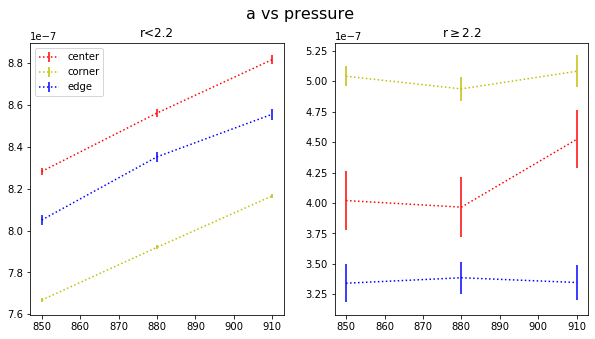

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('a vs pressure',fontsize=16)
y = np.array([850,880,910])
ax1.errorbar(y,a[0:3],yerr=erra[0:3],fmt='r',
            linestyle=ls,label='center')
ax1.errorbar(y,a[3:6],yerr=erra[3:6],fmt='y',label='corner',
            linestyle=ls)
ax1.errorbar(y,a[6:9],yerr=erra[6:9],fmt='b',label='edge',
            linestyle=ls)
ax2.errorbar(y,a2[0:3],yerr=erra2[0:3],fmt='r',label='center',
            linestyle=ls)
ax2.errorbar(y,a2[3:6],yerr=erra2[3:6],fmt='y',label='corner',
            linestyle=ls)
ax2.errorbar(y,a2[6:9],yerr=erra2[6:9],fmt='b',label='edge',
            linestyle=ls)
ax1.set_title('r<2.2')
ax2.set_title(r'r$\geq2.2$')
#plt.legend()
ax1.legend()
plt.show()

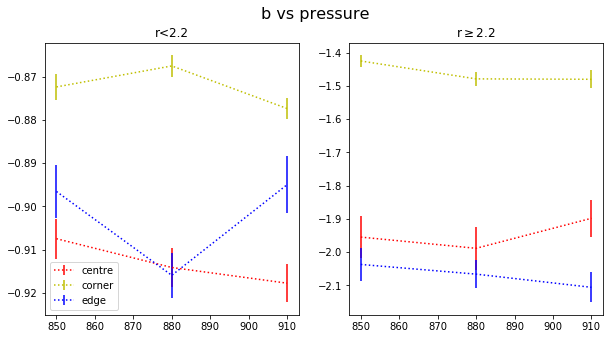

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('b vs pressure',fontsize=16)
y = np.array([850,880,910])
ax1.errorbar(y,b[0:3],yerr=errb[0:3],
            linestyle=ls,fmt='r',label='centre')
ax1.errorbar(y,b[3:6],yerr=errb[3:6],label='corner',
            linestyle=ls,fmt='y')
ax1.errorbar(y,b[6:9],yerr=errb[6:9],label='edge',
            linestyle=ls,fmt='b')
ax2.errorbar(y,b2[0:3],yerr=errb2[0:3],label='centre',
            linestyle=ls,fmt='r')
ax2.errorbar(y,b2[3:6],yerr=errb2[3:6],label='corner',
            linestyle=ls,fmt='y')
ax2.errorbar(y,b2[6:9],yerr=errb2[6:9],label='edge',
            linestyle=ls,fmt='b')
ax1.set_title('r<2.2')
ax2.set_title(r'r$\geq2.2$')
#plt.legend()
ax1.legend()
plt.show()

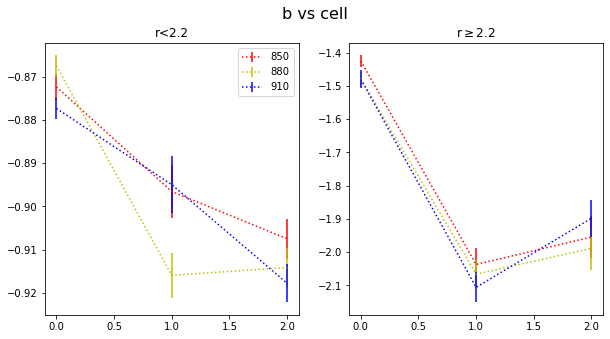

In [62]:
regions2 = [TLL850, TLR850, CTL850, TLL880, TLR880, CTL880, TLL910, TLR910, CTL910]
#corner edge centre
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions2)):
    popt,perr,popt2,perr2 = perform_fit(regions2[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('b vs cell',fontsize=16)
y = np.array([0,1,2])
ax1.errorbar(y,b[0:3],yerr=errb[0:3],
            linestyle=ls,fmt='r',label='850')
ax1.errorbar(y,b[3:6],yerr=errb[3:6],label='880',
            linestyle=ls,fmt='y')
ax1.errorbar(y,b[6:9],yerr=errb[6:9],label='910',
            linestyle=ls,fmt='b')
ax2.errorbar(y,b2[0:3],yerr=errb2[0:3],label='centre',
            linestyle=ls,fmt='r')
ax2.errorbar(y,b2[3:6],yerr=errb2[3:6],label='corner',
            linestyle=ls,fmt='y')
ax2.errorbar(y,b2[6:9],yerr=errb2[6:9],label='edge',
            linestyle=ls,fmt='b')
ax1.set_title('r<2.2')
ax2.set_title(r'r$\geq2.2$')
#plt.legend()
ax1.legend()
ax1.set_xticklabels(['corner','edge','center'],minor=True)

plt.show()

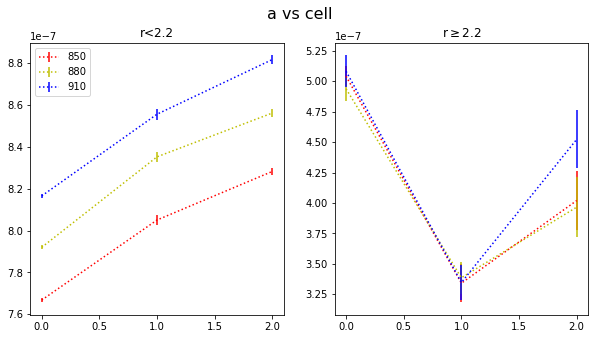

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('a vs cell',fontsize=16)
y = np.array([0,1,2])
ax1.errorbar(y,a[0:3],yerr=erra[0:3],fmt='r',
            linestyle=ls,label='850')
ax1.errorbar(y,a[3:6],yerr=erra[3:6],fmt='y',label='880',
            linestyle=ls)
ax1.errorbar(y,a[6:9],yerr=erra[6:9],fmt='b',label='910',
            linestyle=ls)
ax2.errorbar(y,a2[0:3],yerr=erra2[0:3],fmt='r',label='center',
            linestyle=ls)
ax2.errorbar(y,a2[3:6],yerr=erra2[3:6],fmt='y',label='corner',
            linestyle=ls)
ax2.errorbar(y,a2[6:9],yerr=erra2[6:9],fmt='b',label='edge',
            linestyle=ls)
ax1.set_title('r<2.2')
ax2.set_title(r'r$\geq2.2$')
#plt.legend()
ax1.legend()
plt.show()

In [68]:
#magnitude scales linearly with pressure

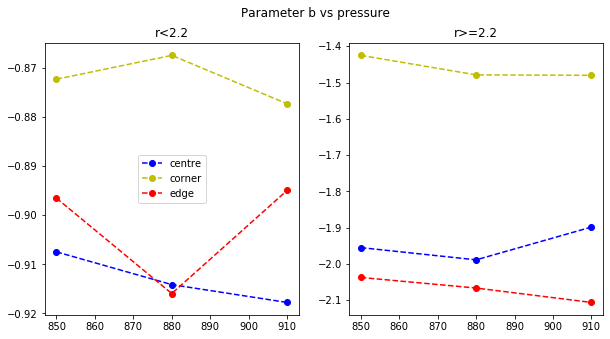

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter b vs pressure')
y = np.array([850,880,910])
ax1.plot(y,b[0:3],'--bo',label='centre')
ax1.plot(y,b[3:6],'--yo',label='corner')
ax1.plot(y,b[6:9],'--ro',label='edge')
ax2.plot(y,b2[0:3],'--bo',label='centre')
ax2.plot(y,b2[3:6],'--yo',label='corner')
ax2.plot(y,b2[6:9],'--ro',label='edge')
ax1.set_title('r<2.2')
ax2.set_title('r>=2.2')
#plt.legend()
ax1.legend()
plt.show()

In [87]:
#shape (which is controlled by param b) does not scale linearly with pressure, since it depends on cell config

pressure i.e. how much gas is in there does not affect parameter b. a ie speed is affected 